# Import all libraries

In [1]:
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
import scipy.cluster.hierarchy as shc
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.metrics import confusion_matrix,classification_report



ModuleNotFoundError: No module named 'pandas'

# Import dataset

In [86]:
df=pd.read_csv(r'C:\Users\Ajay\Documents\Code\EXL\Projects\Retail Pharmacy\TextClustering\Data\2021VAERSDATA.csv',encoding='latin1')

C:\Users\Ajay\AppData\Local\Temp\ipykernel_16580\2388265349.py:1: DtypeWarning: Columns (7,12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(r'C:\Users\Ajay\Documents\Code\EXL\Projects\Retail Pharmacy\TextClustering\Data\2021VAERSDATA.csv',encoding='latin1')


# Helper functions

In [75]:
def plot_kmeans(embeddings, k_range):
    '''
    Plot SSE and silhouette score for kmeans clustering for a range of k values
    Arguments:
        embeddings: array, sentence embeddings
        k_range: range, values of k to evaluate for kmeans clustering  
    '''
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(embeddings, kmeans.predict(embeddings))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

def search_cluster_size(embeddings, size_range):
    '''
    Scan HDBSCAN min_cluster_size values and return results
    Arguments:
        embeddings: embeddings to use
        size_range: range of min_cluster_size hyperparameter values to scan
    Returns:
        result_df: dataframe of min_cluster_size, total number of clusters,
                   and percent of data labeled as noise
    '''
    
    results = []
    
    for i in size_range:
        min_cluster_size = i
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['min_cluster_size', 
                                               'label_count', 'noise'])
    
    return result_df

def random_search(embeddings, space, num_evals):
    '''
    Random search of HDBSCAN hyperparameter spcae
    Arguments:
        embeddings: embeddings to use
        space: dict, hyperparameter space to search with keys of
               'min_cluster_size' and 'min_samples' and values as ranges
        num_evals: int, number of trials to run
    Returns:
        result_df: dataframe of run_id, min_cluster_size, min_samples, 
                   total number of clusters, and percent of data labeled as noise
    
    '''
    
    results = []
    
    for i in range(num_evals):
        min_cluster_size = random.choice(space['min_cluster_size'])
        min_samples = random.choice(space['min_samples'])
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           min_samples = min_samples,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([i, min_cluster_size, min_samples, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'min_cluster_size', 'min_samples', 
                                               'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

# Removing null values and data preprocessing 

In [87]:
df = df[df['SYMPTOM_TEXT'].notna()]

In [88]:
# select only 2000 records 
df=df[0:2000]

In [89]:
# data preprocessing step where some characters which are not required are removed 
# 1. special characters
# 2. digits in this use case
# 3. extra spaces
# 4. some words like block are used in lot of sentences and is surrounded by other characters ..needed to be separated
# 5 words less than  3 and greater than 20 add no meaning to data , so those are also removed

worddic={}
rows=[]
for i in df.index:
    row=df['SYMPTOM_TEXT'][i]
    row=df['SYMPTOM_TEXT'][i].lower()
    
    row=re.sub('[^A-Za-z0-9]+', ' ', row)
    tokens=row.split(" ")
    tokens=[t.lower() for t in tokens if len(t)>=3 and len(t)<20]
    text=" ".join(tokens)

#     row=preprocess(text)
    tokens=row.split(" ")
    for j in tokens:
        worddic[j]=worddic.get(j,0)+1
    rows.append(row)
    

# this is how data looks like

In [90]:
rows

['right side of epiglottis swelled up and hinder swallowing pictures taken benadryl tylenol taken',
 'approximately 30 min post vaccination administration patient demonstrated sob and anxiousness assessed at time of event heart sounds normal lung sounds clear vitals within normal limits for patient o2 91 on 3 liters nc continuous flow 2 consecutive nebulized albuterol treatments were administered at approximately 1 5 hours post reaction patients sob and anxiousness had subsided and the patient stated that they were feel much better ',
 'about 15 minutes after receiving the vaccine the patient complained about her left arm hurting she also complained of chest tightness and difficulty swallowing patient also had vision changes we gave the patient 1 tablet of benadryl 25 mg and called ems services ems checked her out and we advised the patient to go to the er to be observed and given more benadryl patient was able to walk out of facility herself ',
 'extreme fatigue dizziness could not li

# KMeans - Bert embedding (all-MiniLM-L6-v2)

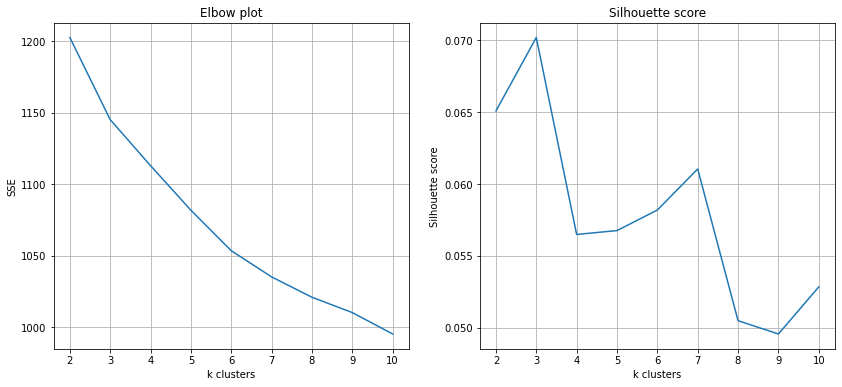

In [103]:
model_st1 = SentenceTransformer('all-MiniLM-L6-v2')
st_embeddings = model_st1.encode(rows)
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(st_embeddings)
k_range = range(2, 11)
plot_kmeans(st_embeddings, k_range)

In [104]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(st_embeddings)
labels=kmeans.predict(st_embeddings)
silhouette_score(st_embeddings,labels)

0.0712932

# KMeans - Bert embedding (all-mpnet-base-v2)

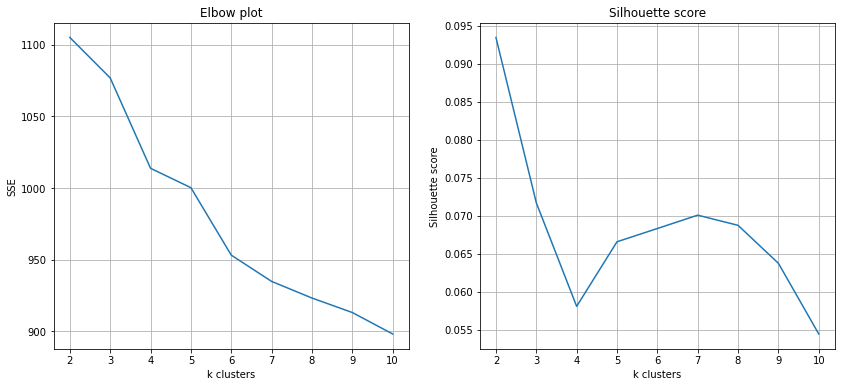

In [105]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
st_embeddings = model_st1.encode(rows)
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(st_embeddings)
k_range = range(2, 11)
plot_kmeans(st_embeddings, k_range)

In [106]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(st_embeddings)
labels=kmeans.predict(st_embeddings)
silhouette_score(st_embeddings,labels)

0.07022734

# KMeans - Bert embedding (paraphrase-mpnet-base-v2)

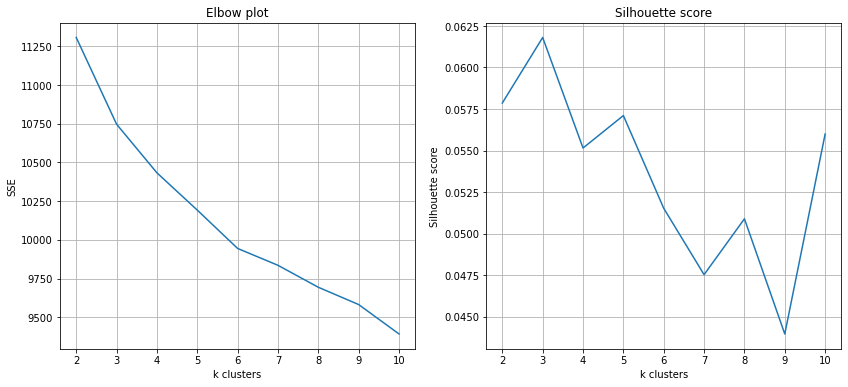

In [107]:
model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')
st_embeddings = model_st1.encode(rows)
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(st_embeddings)
k_range = range(2, 11)
plot_kmeans(st_embeddings, k_range)

In [108]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(st_embeddings)
labels=kmeans.predict(st_embeddings)
silhouette_score(st_embeddings,labels)

0.062312268

# Data preprocessing for Non - contextual embedding - TF-idf and BOW

In [109]:
# NLP text tokens


def tokenize(text):
    words=word_tokenize(text)
    return words
# removing stopwords
stop=stopwords.words('english')
puncs=list(string.punctuation)
stop=stop+puncs
def remove_stops(words):
    cleaned=[w for w in words if not w.lower() in stop]
    return cleaned
# document parsing
def pos_tg(cleaned):
    pos=np.array(pos_tag(cleaned))
    return pos

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# lemitizing
lemmatizer=WordNetLemmatizer()

def lemmatize(pos):
    lemmatized=[]
    for w in pos:
        lemmatizedword=lemmatizer.lemmatize(w[0],get_simple_pos(w[1]))
        lemmatized.append(lemmatizedword)
    return lemmatized
def preprocess(text):
    words=tokenize(text)
    cleaned=remove_stops(words)
    pos=pos_tag(cleaned)
    lemmatized=lemmatize(pos)
    preprocessed=" ".join(lemmatized)
#     sno = nltk.stem.SnowballStemmer('english')
    
    return preprocessed

In [110]:
#
# data preprocessing step where some characters which are not required are removed 
# 1. special characters
# 2. digits in this use case
# 3. extra spaces
# 4. some words like block are used in lot of sentences and is surrounded by other characters ..needed to be separated
# 5 words less than  3 and greater than 20 add no meaning to data , so those are also removed
worddic={}
rows=[]
for i in df.index:
    row=df['SYMPTOM_TEXT'][i]
    row=df['SYMPTOM_TEXT'][i].lower()
    
    row=re.sub('[^A-Za-z]+', ' ', row)
    tokens=row.split(" ")
    tokens=[t.lower() for t in tokens if len(t)>=3 and len(t)<20]
    text=" ".join(tokens)

    row=preprocess(text)
    tokens=row.split(" ")
    for j in tokens:
        worddic[j]=worddic.get(j,0)+1
    rows.append(row)
    

# Kmeans with BOW

In [111]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(rows)
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn.head()

C:\Users\Ajay\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaox,aat,abate,abd,abdomen,abdominal,abduct,ability,able,abnormal,abnormality,abrasion,abrupt,abruptly,absolutely,abuse,accelerate,accept,access,accompanied,accompany,accomplish,accord,account,accross,accurate,acetamenophen,acetaminophen,acetonide,ach,ache,achey,achilles,achiness,aching,achy,achyleft,acid,acidic,acoustic,acquire,across,act,action,activate,activation,active,activity,actual,actually,acupuncture,acute,acutely,acyclovir,add,adderall,addition,additional,additionally,address,ademetionine,adenopathy,adjacent,adjust,adjustment,adl,adls,admin,administer,administering,administration,administrative,administrtaion,adminsitration,admission,admit,admitted,adn,adrenaline,adrs,adult,advair,adverse,adversely,adversions,advice,advil,advils,advisable,advise,advised,afebrile,affect,affected,afib,afraid,aftermath,afternoon,afterward,afterwards,age,agency,ageusia,aggregate,agitate,agitation,ago,agree,agreement,ahead,aid,aide,air,airway,airways,alarm,albuterol,alcohol,alcoholic,alert,aleve,alittle,allegra,allergic,allergist,allergy,alleviate,alleviated,allow,allowa,almost,alone,along,alot,alprazolam,already,also,alter,altered,alternate,alternative,although,always,ama,amaze,ambulance,ambulate,ambulated,ambulation,ambulatory,amount,amoxicillin,amr,analgesic,analysis,anaphylactic,anaphylactoid,anaphylaxis,anatomical,anecdotally,anemia,anesthetist,anew,anger,angina,angio,angioedema,angry,ankes,ankle,anomaly,anorexia,anosmia,another,answer,antecubital,anterior,anti,antibiotic,antibiotics,antibody,anticipate,antiemetic,antigens,antihistamine,antiniotic,antiphospholipid,antipyretic,antiseizure,antiviral,anxiety,anxious,anxiousness,anymore,anyone,anything,anyway,anywhere,apap,apart,aphasia,aphasic,apnea,apparent,apparently,appear,appearance,appeared,appendectomy,appendicitis,appetite,appitites,apple,applicable,applied,apply,appointment,appreciate,approach,appropriate,appropriately,approx,approximate,approximately,appt,apr,apreading,april,aprn,aprox,aprx,arch,area,arm,armpit,around,arouse,arrest,arrhythmia,arrival,arrive,arrived,artery,arthralgia,arthralgias,arthritic,arthritis,asap,ashen,aside,...,unremarkable,unresolved,unresponsive,unsolicited,unspecified,unstable,unsteady,unsuccessful,unsure,unusual,unusually,unwell,update,upon,upper,upright,upset,upstairs,urge,urgent,uric,urinary,urination,urine,urticaria,us,use,used,usp,ustekinumab,usual,usually,uterine,uti,utilized,uvula,vac,vaccin,vaccinate,vaccinated,vaccination,vaccinator,vaccine,vacinne,vaer,vaers,vagal,vagina,vague,valacyclovir,valid,valium,valtrex,valve,valvular,variance,various,vary,vaseline,vaso,vasovagal,vastly,vax,vaxx,vegetarian,vehicle,vein,velamentous,ventilation,ventral,ventricular,verbalize,verbalizes,verge,verify,versa,versus,vertiginous,vertigo,vesicle,vessel,vest,via,vial,vibration,vice,victim,video,vigorous,violent,violently,viral,virtual,virus,visible,visibly,vision,visit,visual,vital,vitals,vitamin,vitamins,vitreous,vivid,voice,voicemail,voiding,voluma,volume,vomit,vomiting,vommiting,vsafe,vtach,vzv,wabbly,waist,wait,waitied,wake,wakefulness,walk,walked,walkiing,walking,wall,wan,want,wanted,warm,warmer,warmness,warmth,warn,wash,watch,watched,water,watery,wave,wax,way,wbc,weak,weaken,weakened,weakness,wear,website,wed,wednesday,week,weekend,weekly,weel,weight,weird,well,wellness,welt,welted,welts,wet,wheal,wheel,wheelchair,wheeze,wheezing,whelp,whenever,whereas,whether,white,whole,whoosh,wide,widespread,width,wierd,wife,willing,wind,window,wipe,wiped,wire,wish,wistar,within,without,witness,wnl,wobbly,woke,woken,wonder,wondering,woozy,word,work,worked,worker,workout,workplace,worksite,workup,workups,worn,worried,worrisome,worry,worse,worsen,worsened,worsening,worst,would,wrap,wright,wrinkle,wrist,wrists,write,writer,wrong,www,xopenex,xophenex,xray,xyzal,yawn,year,yearly,yearsold,yellow,yes,yesterdat,yesterday,yet,young,zero,zofan,zofran,zone,zophran,zoster,zostervac,zurtec,zyrtec
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

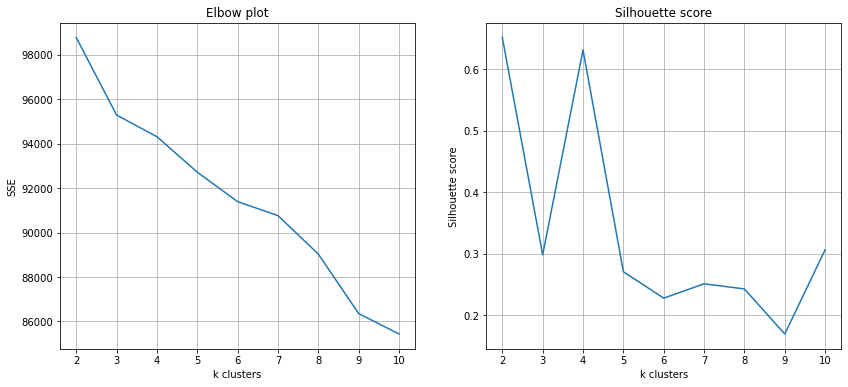

In [127]:
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(X)
k_range = range(2, 11)
plot_kmeans(X, k_range)

In [128]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(X)
labels=kmeans.predict(X)
silhouette_score(X,labels)

0.6488008006655857

In [113]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(X)
labels=kmeans.predict(X)
silhouette_score(X,labels)

0.6439732574277236

# Kmeans with TF-IDF

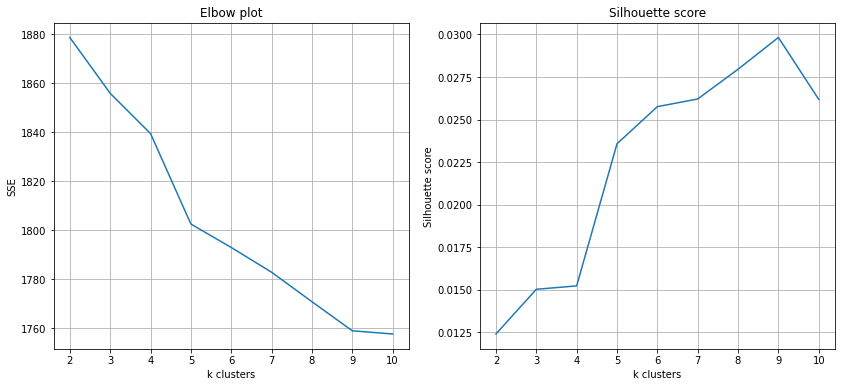

In [129]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_transformed_vector = tfidf_vectorizer.fit_transform(rows)
tfidf_transformed_vector.shape
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(tfidf_transformed_vector)
k_range = range(2, 11)
plot_kmeans(tfidf_transformed_vector, k_range)

In [130]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=1)
labels=kmeans.fit_predict(tfidf_transformed_vector)

silhouette_score(tfidf_transformed_vector,labels)

0.02397829369303264

# HDBSCAN 

# HDBSCAN with Bert embedding ('paraphrase-mpnet-base-v2')

In [138]:
# Normalize the embeddings to unit length
model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')
st_embeddings3 = model_st1.encode(rows)

In [131]:


size_range = range(2,11)
search_cluster_size(st_embeddings, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,70,0.8215
1,3,8,0.2930
2,4,7,0.2815
3,5,7,0.3140
4,6,5,0.3460
5,7,4,0.3750
6,8,4,0.3945
7,9,4,0.4115
8,10,4,0.4245


In [133]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=10, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(st_embeddings)

labels = clusters_hdbscan.labels_
len(np.unique(labels))
from sklearn import metrics
metrics.silhouette_score(st_embeddings,labels)

0.02908854

# HDBSCAN with Bert embedding ('all-mpnet-base-v2')

In [135]:

model_st1 = SentenceTransformer('all-mpnet-base-v2')
st_embeddings1 = model_st1.encode(rows)

In [137]:
size_range = range(2,11)
search_cluster_size(st_embeddings1, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,73,0.7865
1,3,8,0.2820
2,4,8,0.3090
3,5,7,0.3415
4,6,5,0.3730
5,7,5,0.3920
6,8,5,0.4060
7,9,4,0.4210
8,10,4,0.4380


In [140]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=3, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(st_embeddings1)

labels = clusters_hdbscan.labels_
len(np.unique(labels))
from sklearn import metrics
metrics.silhouette_score(st_embeddings1,labels)

0.041680716

# HDBSCAN with Bert embedding ('all-MiniLM-L6-v2')

In [141]:
# Normalize the embeddings to unit length
model_st1 = SentenceTransformer('all-MiniLM-L6-v2')
st_embeddings2 = model_st1.encode(rows)


In [142]:
size_range = range(2,11)
search_cluster_size(st_embeddings2, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,72,0.7980
1,3,8,0.2805
2,4,8,0.3185
3,5,6,0.3520
4,6,6,0.3740
5,7,6,0.3940
6,8,6,0.4140
7,9,5,0.4150
8,10,4,0.3370


In [144]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=10, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(st_embeddings2)

labels = clusters_hdbscan.labels_
len(np.unique(labels))
from sklearn import metrics
metrics.silhouette_score(st_embeddings2,labels)

0.041253462

# HDBSCAN with TF-idf

In [145]:
search_cluster_size(tfidf_transformed_vector, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,86,0.8415
1,3,27,0.9090
2,4,15,0.9325
3,5,8,0.7860
4,6,5,0.4565
5,7,4,0.4950
6,8,4,0.5260
7,9,4,0.5485
8,10,4,0.5690


In [147]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=10, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(tfidf_transformed_vector)

labels = clusters_hdbscan.labels_
len(np.unique(labels))
from sklearn import metrics
metrics.silhouette_score(tfidf_transformed_vector,labels)

0.01747961968232152

# HDBSCAN with BOW

In [148]:
search_cluster_size(X, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,187,0.1960
1,3,136,0.2490
2,4,115,0.2810
3,5,9,0.1295
4,6,5,0.1295
5,7,5,0.1450
6,8,4,0.1345
7,9,4,0.1285
8,10,5,0.1815


In [150]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=9, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(X)

labels = clusters_hdbscan.labels_
len(np.unique(labels))
from sklearn import metrics
metrics.silhouette_score(X,labels)

0.296717781507606

# HDBSCAN

# Hierarchical clustering

# Hierarchical clustering with Bert embedding ('paraphrase-mpnet-base-v2')

In [155]:

st_embeddings_norm = st_embeddings /  np.linalg.norm(st_embeddings3, axis=1, keepdims=True)
# Perform clustering

agglom_model = AgglomerativeClustering(n_clusters=3)
agglom_model.fit(st_embeddings_norm)
cluster_assignment = agglom_model.labels_
silhouette_score(st_embeddings_norm,cluster_assignment)

0.047647305

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X.toarray(), method='ward'))

# Hierarchical clustering with Bert embedding (all-mpnet-base-v2)

In [170]:

st_embeddings_norm = st_embeddings /  np.linalg.norm(st_embeddings1, axis=1, keepdims=True)
# Perform clustering

agglom_model = AgglomerativeClustering(n_clusters=3)
agglom_model.fit(st_embeddings_norm)
cluster_assignment = agglom_model.labels_
silhouette_score(st_embeddings_norm,cluster_assignment)

0.043803092

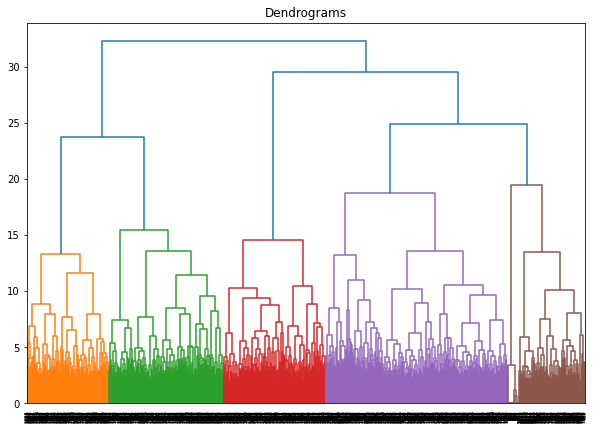

In [171]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(st_embeddings_norm, method='ward'))

# Hierarchical clustering with Bert embedding (all-MiniLM-L6-v2)

In [169]:
st_embeddings_norm = st_embeddings /  np.linalg.norm(st_embeddings2, axis=1, keepdims=True)
# Perform clustering

agglom_model = AgglomerativeClustering(n_clusters=2)
agglom_model.fit(st_embeddings_norm)
cluster_assignment = agglom_model.labels_
silhouette_score(st_embeddings_norm,cluster_assignment)

0.043552298

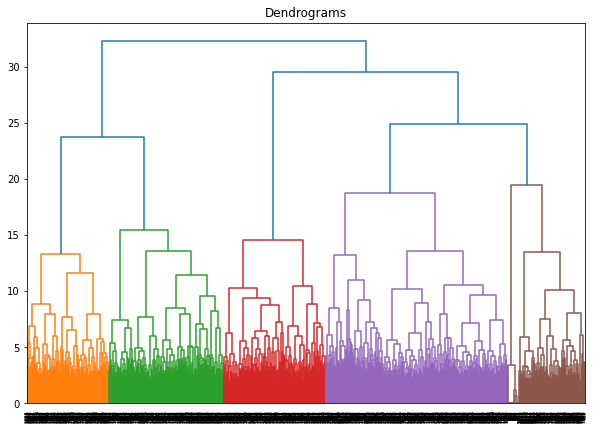

In [166]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(st_embeddings_norm, method='ward'))

# Hierarchical clustering with Tf-IDF

In [160]:

# st_embeddings_norm = st_embeddings /  np.linalg.norm(tfidf_transformed_vector, axis=1, keepdims=True)
# Perform clustering

agglom_model = AgglomerativeClustering(n_clusters=3)
agglom_model.fit(tfidf_transformed_vector.toarray())
cluster_assignment = agglom_model.labels_
silhouette_score(tfidf_transformed_vector.toarray(),cluster_assignment)

0.024248304898355683

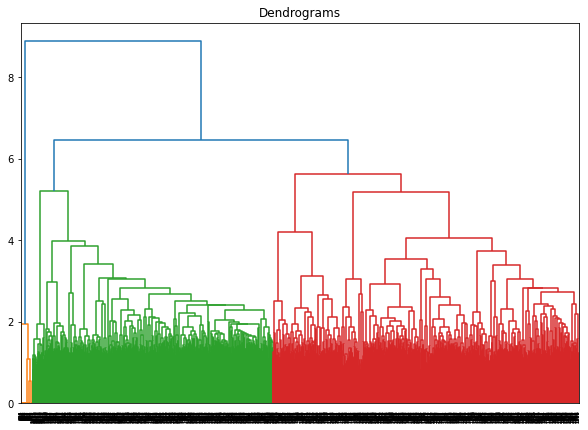

In [164]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(tfidf_transformed_vector.toarray(), method='ward'))

# Hierarchical clustering with BOW

In [163]:
agglom_model = AgglomerativeClustering(n_clusters=2)
agglom_model.fit(X.toarray())
cluster_assignment = agglom_model.labels_
silhouette_score(X.toarray(),cluster_assignment)

0.6444042337155281

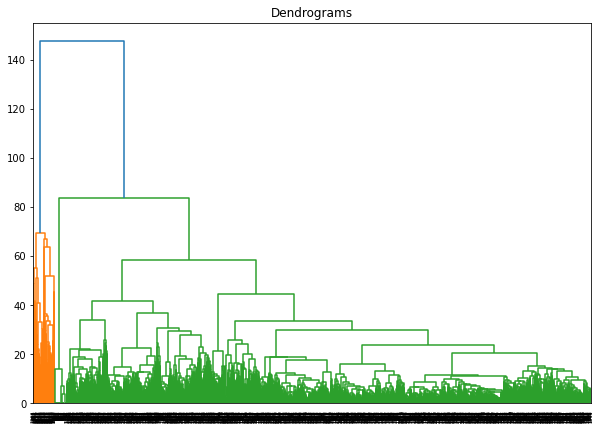

In [162]:

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X.toarray(), method='ward'))

# Conclusion

In [ ]:
As we can see from the data 